In [57]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import scipy.optimize as opt

Helper Functions

In [58]:
def calculate_orbits(dict, ics, num_steps):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)

    n_samples = 100
    ra_samples = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec_samples = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist_samples = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra_samples = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec_samples = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv_samples = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    ics_list = []
    for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
        sc = coord.SkyCoord(ra=ra * u.degree,
                    dec=dec * u.degree,
                    distance=dist * u.kpc,
                    pm_ra_cosdec=pmra * (u.mas / u.yr),
                    pm_dec=pmdec * (u.mas / u.yr),
                    radial_velocity=rv * (u.km / u.s),
                    frame="icrs")
        gc = sc.transform_to(coord.Galactocentric)
        ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
        ics_list.append(ics)

    orbits = []
    orbits.append(orbit)
    for ics in ics_list:
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
        orbits.append(orbit)

    return orbits

First, define a gravitational potential.

In [59]:
pot = gp.MilkyWayPotential()

Leo I

In [60]:
dwarf_dict = {
    'ra': 152.117175, #degree
    'e_ra': 0.0001, #degree
    'dec': 12.3065, #degree
    'e_dec': 0.0001, #degree
    'dist': 254.0, #kpc
    'e_dist': 15.5, #kpc
    'pmra': -0.007, #mas/yr
    'e_pmra': 0.035, #mas/yr
    'pmdec': -0.119, #mas/yr not updated
    'e_pmdec': 0.026, #mas/yr not updated
    'rv': 282.9, #km/s
    'e_rv': 0.5, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dict['ra'] * u.degree,
    dec=dict['dec'] * u.degree,
    distance=dict['dist'] * u.kpc,
    pm_ra_cosdec=dict['pmra'] * (u.mas / u.yr),
    pm_dec=dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

        Use name instead. [gala.dynamics.core]


HVS 14

In [61]:
dict14 = {
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs14 = coord.SkyCoord(
    ra=dict['ra'] * u.degree,
    dec=dict['dec'] * u.degree,
    distance=dict['dist'] * u.kpc,
    pm_ra_cosdec=dict['pmra'] * (u.mas / u.yr),
    pm_dec=dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs14_GC = hvs14.transform_to(coord.Galactocentric)
hvs14_ics = gd.PhaseSpacePosition(pos=hvs14_GC.cartesian.xyz, vel=hvs14_GC.velocity.d_xyz)

HVS 23

In [62]:
dict23 = {
    'ra': 329.1209186025, #degree
    'e_ra': 0.0001, #degree
    'dec': 0.9122807743, #degree
    'e_dec': 0.0001, #degree
    'dist': 114.87, #kpc
    'e_dist': 20.10, #kpc
    'pmra': -1.21, #mas/yr
    'e_pmra': 1.29, #mas/yr
    'pmdec': -2.46, #mas/yr
    'e_pmdec': 1.50, #mas/yr
    'rv': 259.30, #km/s
    'e_rv': 9.80, #km/s
    }
hvs23 = coord.SkyCoord(
    ra=dict23['ra'] * u.degree,
    dec=dict23['dec'] * u.degree,
    distance=dict23['dist'] * u.kpc,
    pm_ra_cosdec=dict23['pmra'] * (u.mas / u.yr),
    pm_dec=dict23['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict23['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs23_GC = hvs23.transform_to(coord.Galactocentric)
hvs23_ics = gd.PhaseSpacePosition(pos=hvs23_GC.cartesian.xyz, vel=hvs23_GC.velocity.d_xyz)

Plot Leo I and HVS 14

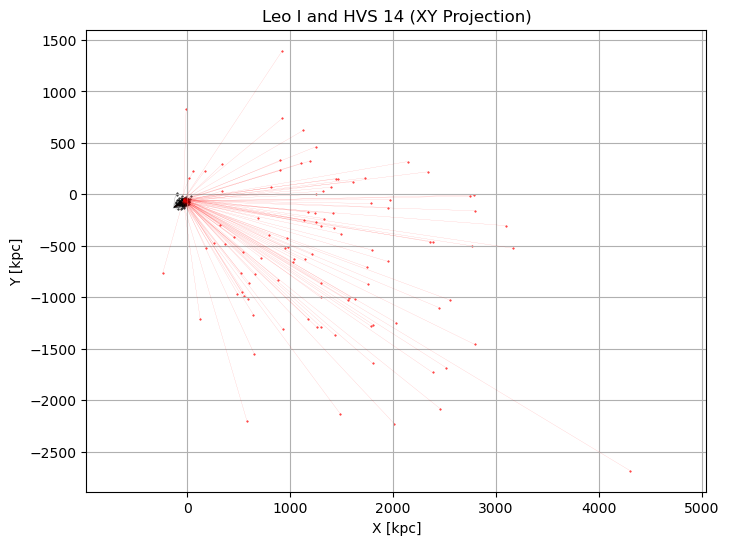

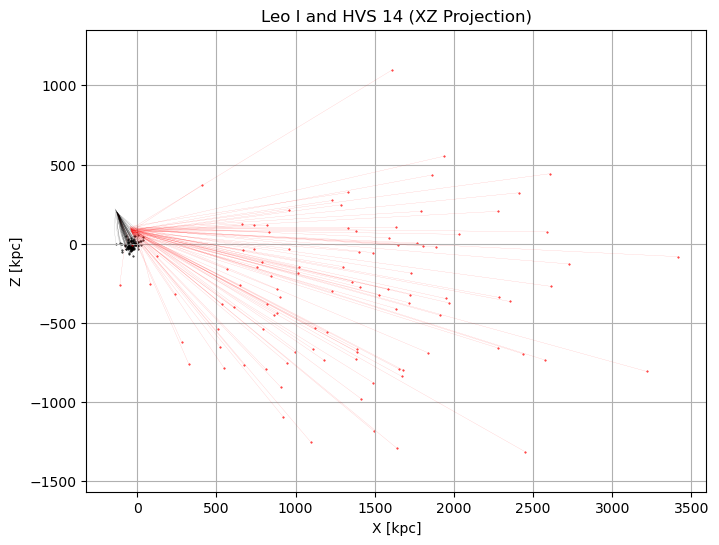

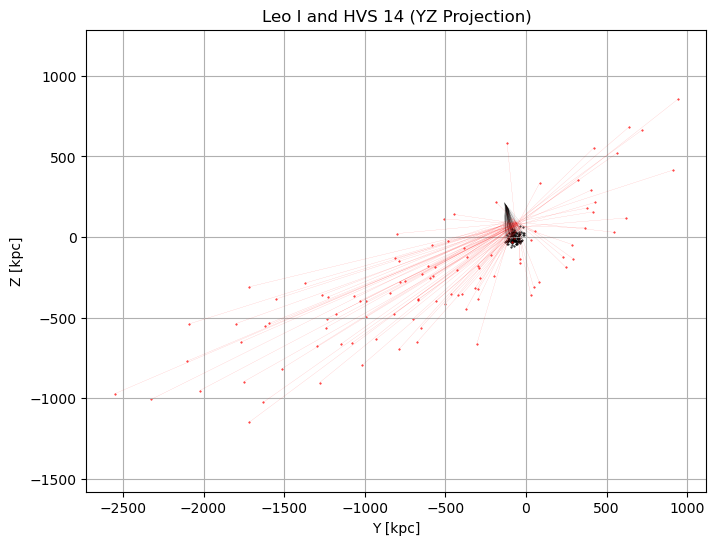

In [69]:
plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict14, hvs14_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='red', marker='o', s=0.2)

plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title('Leo I and HVS 14 (XY Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict14, hvs14_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='red', marker='o', s=0.2)

plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')
plt.title('Leo I and HVS 14 (XZ Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict14, hvs14_ics, 9463.436712209297):
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='red', marker='o', s=0.2)

plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')
plt.title('Leo I and HVS 14 (YZ Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()

Plot Leo I and HVS 23

        Use name instead. [gala.dynamics.core]


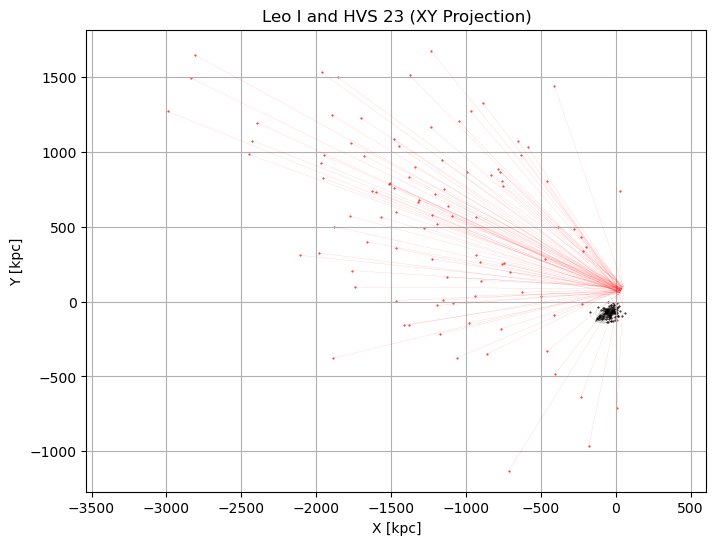

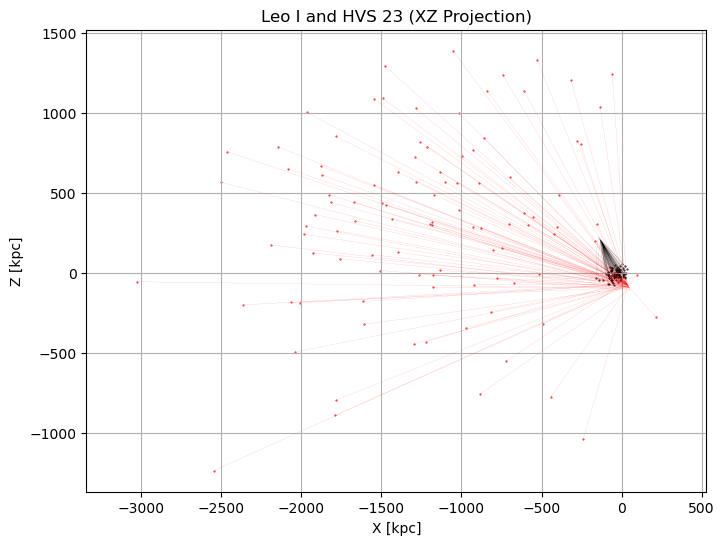

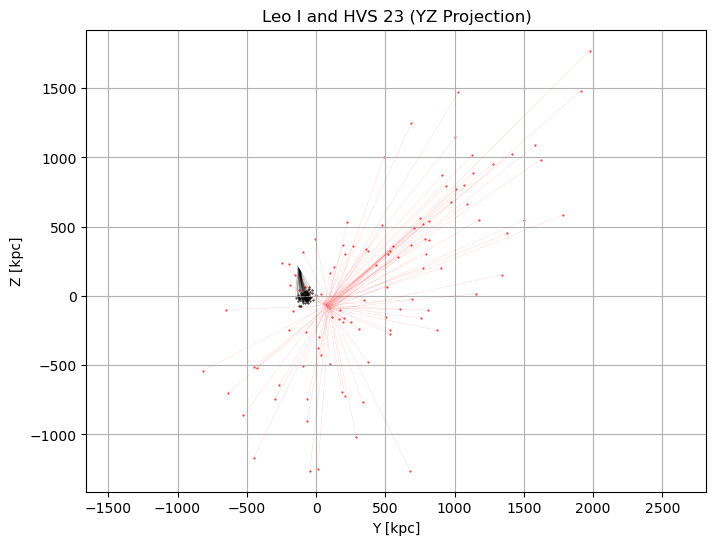

In [70]:
plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict23, hvs23_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='red', marker='o', s=0.2)

plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title('Leo I and HVS 23 (XY Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict23, hvs23_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='red', marker='o', s=0.2)

plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')
plt.title('Leo I and HVS 23 (XZ Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()

plt.figure(figsize=(8, 6))

for orbit in calculate_orbits(dwarf_dict, dwarf_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)

for orbit in calculate_orbits(dict23, hvs23_ics, 9507.480174422486):
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='red', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='red', marker='o', s=0.2)

plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')
plt.title('Leo I and HVS 23 (YZ Projection)')
plt.axis('equal')
plt.grid(True)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.show()